In [1]:
mjj_window = np.array([-30.,+30.])+125.
# mjj_window = np.array([-125,+3000.])+125.
MX_categories = np.array([250.,340.,480.,1e+6])
MVA_categories = np.array([0.88,0.97,0.99,1.1])


In [2]:
import os
# import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils


Welcome to ROOTaaS 6.06/05


In [3]:
import ROOT as RT
from glob import glob 

In [4]:
fnames = glob('/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/outfiles/20170711_highMassCut/GluGluToHHTo2B2G_node_*_13TeV-madgraph_preselection.root')
# fnames = glob('/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/outfiles/20170828_optimizedCuts_withDR_dijetMass/GluGluToHHTo2B2G_node_*_13TeV-madgraph_preselection.root')
# fnames = glob('/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/outfiles/20170828_optimizedCuts_noDR_minDRGJet_dijetMass/GluGluToHHTo2B2G_node_*_13TeV-madgraph_preselection.root')

In [5]:
nodes = { name.split("node")[1].split("_")[1] : RT.TFile.Open(name) for name in fnames } 

In [6]:
keys = sorted(nodes.keys())

In [7]:
import root_pandas as rpd
import pandas as pd

dfs = []

for key in keys:
    inode = int(key) if key != 'SM' else 0
    idf = rpd.read_root(nodes[key].GetName())
    idf['proc'] = np.ones((idf.shape[0],1),dtype=np.int32)*inode
    dfs.append(idf)

df = pd.concat(dfs)

In [8]:
df.describe()

,MX,isSignal,Mgg,weight,Mjj,MVAOutput,proc
count,240664.000000,240664.0,240664.000000,2.406640e+05,240664.000000,240664.000000,240664.000000
mean,500.851070,1.0,124.370558,7.194168e-04,116.169506,0.832843,6.996094
std,229.600348,0.0,2.140734,2.823019e-04,24.438915,0.267259,3.951105
min,250.003876,1.0,100.046875,1.375026e-07,60.000385,0.001108,0.000000
25%,324.410507,1.0,123.854893,6.455219e-04,100.844968,0.819936,4.000000
50%,443.419952,1.0,124.688671,7.417856e-04,118.481887,0.964424,7.000000
75%,605.132126,1.0,125.343195,8.603907e-04,131.300765,0.991148,11.000000
max,2783.885742,1.0,178.378448,1.229896e-03,179.999616,0.999072,13.000000


In [9]:
df['Mjj_bin'] = pd.cut( df.Mjj, mjj_window )

In [10]:
df['MX_bin'] = pd.cut(df.MX, MX_categories)

In [11]:
df['MVA_bin'] = pd.cut(df.MVAOutput, MVA_categories )

In [12]:
df['selected'] = (~df['Mjj_bin'].isnull() & ~df['MVA_bin'].isnull()).astype(np.float32)*df['weight']

In [13]:
grouped = df.groupby('proc')

In [14]:
(grouped['selected']).sum() / grouped['weight'].sum()

proc
0     0.572759
2     0.544162
3     0.589822
4     0.555515
5     0.471239
6     0.581529
7     0.580197
8     0.448320
9     0.497717
10    0.522256
11    0.562153
12    0.631453
13    0.645657
dtype: float64

In [44]:
def plot_projection(grp,group,xvar,categories,bins=200,range=None):
    if group == 0:
        icell = 1
        label = "SM"
    else:
        icell = group + 3
        label = str(group)
    plt.subplot(4,4,icell)
    vals,_,_ = plt.hist(grp[xvar],weights=grp['weight'],bins=bins,range=range,label="all events")
    plt.hist(grp[xvar],weights=grp['selected'],bins=bins,range=range,label="selected events")
    plt.hist(categories,bins=bins,range=range,weights=vals.max()*np.ones_like(categories),label="boundaries")
    plt.xlabel(xvar)
    plt.ylabel("A.U.")
    plt.title("Node: %s" % label)
    plt.legend()
    # plt.show()

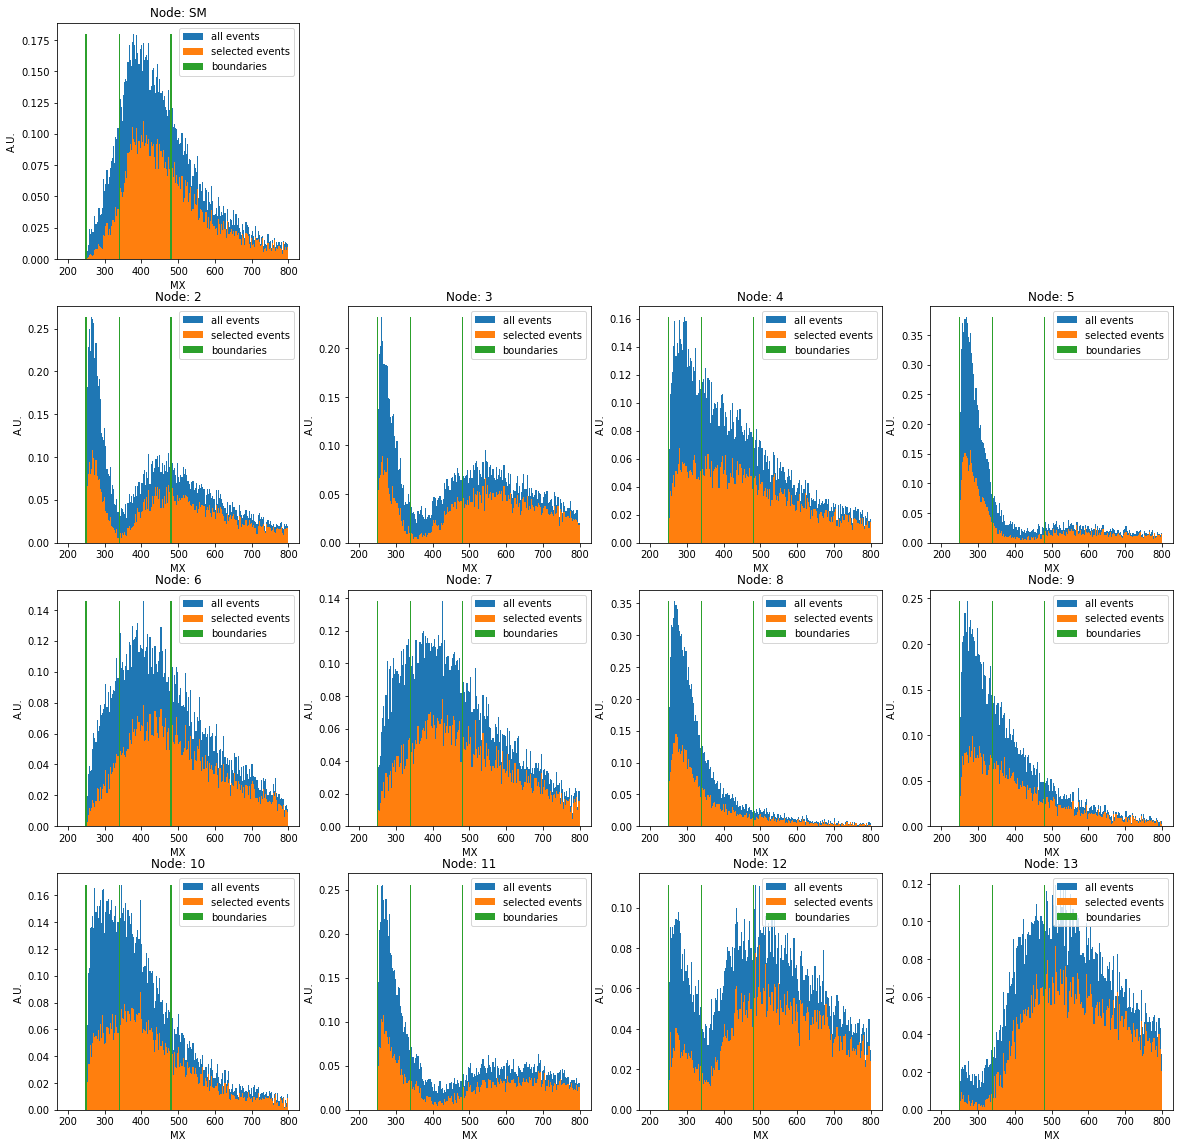

In [45]:
# gouped['MX'].plot.hist(bins=200,range=[200,800],alpha=0.5,sharex=False)
plt.figure(figsize=(20,20))
for group in grouped.groups:
    grp = grouped.get_group(group)
    plot_projection(grp,group,'MX',MX_categories,bins=200,range=[200.,800.])
#     plt.hist(grp['MX'],weights=grp['weight'],bins=200,range=[200.,800.],label="all events")
#     plt.hist(grp['MX'],weights=grp['selected'],bins=200,range=[200.,800.],label="selected events")
#     print(group)
#     plt.hist(MX_categories,bins=200,range=[200,800],weights=0.15*np.ones_like(MX_categories),label="boundaries")
#     plt.xlabel("MX")
#     plt.ylabel("A.U.")
#     plt.title("Node: %d" % group)
#     plt.show()
plt.show()

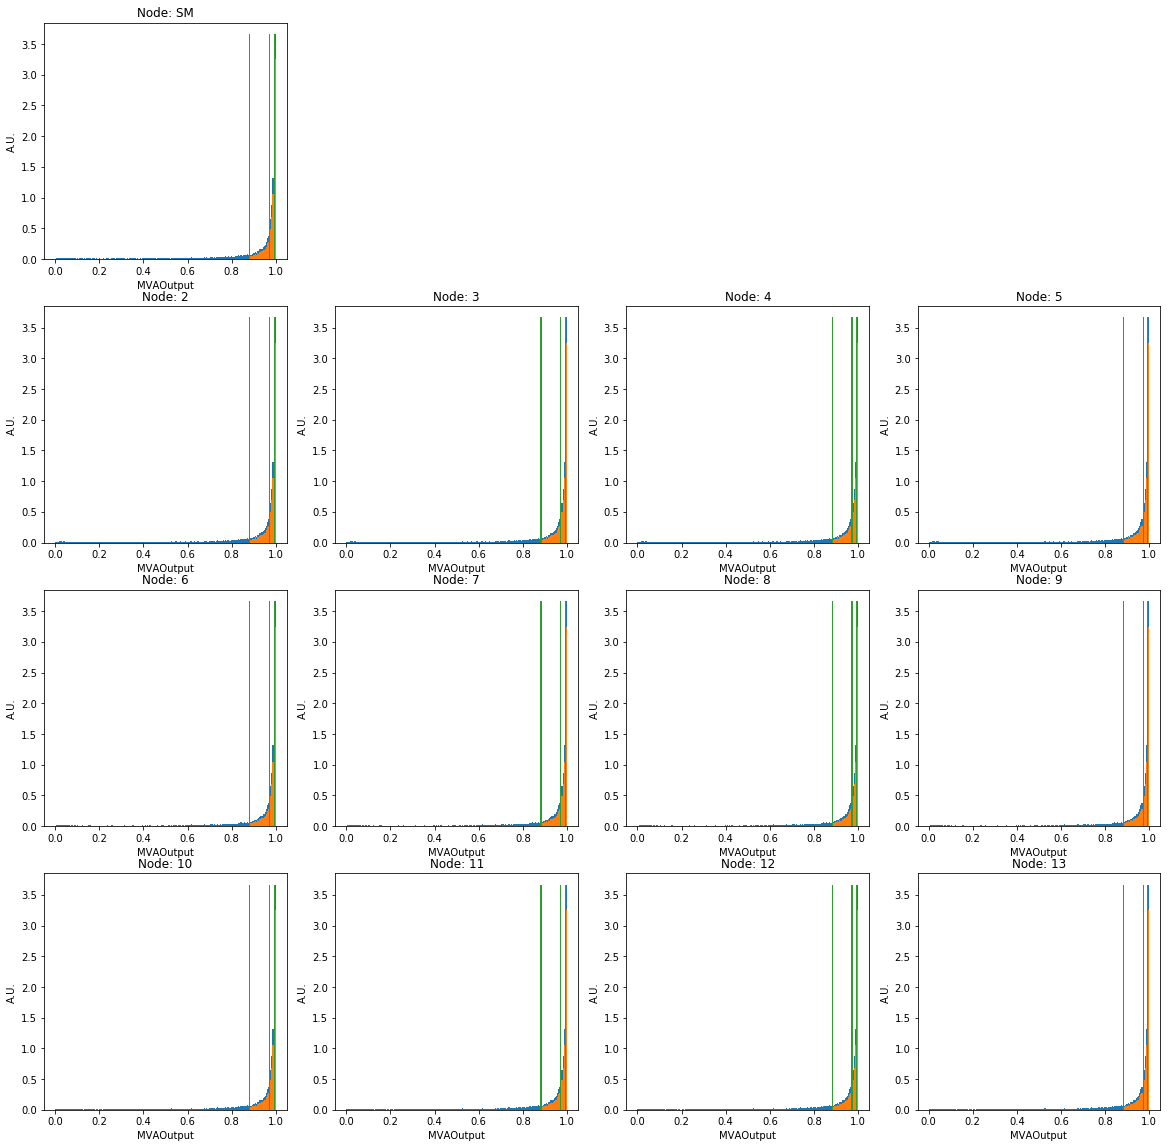

In [41]:
plt.figure(figsize=(20,20))
for group in grouped.groups:
    plot_projection(grp,group,'MVAOutput',MVA_categories,bins=200,range=[0.,1.])
#     grp = grouped.get_group(group)
#     plt.hist(grp['MVAOutput'],weights=grp['weight'],bins=200,range=[0.,1.])
#     plt.hist(grp['MVAOutput'],weights=grp['selected'],bins=200,range=[0.,1.])
#     plt.hist(MVA_categories,bins=200,range=[0.,1.],weights=1.5*np.ones_like(MX_categories))
plt.show()

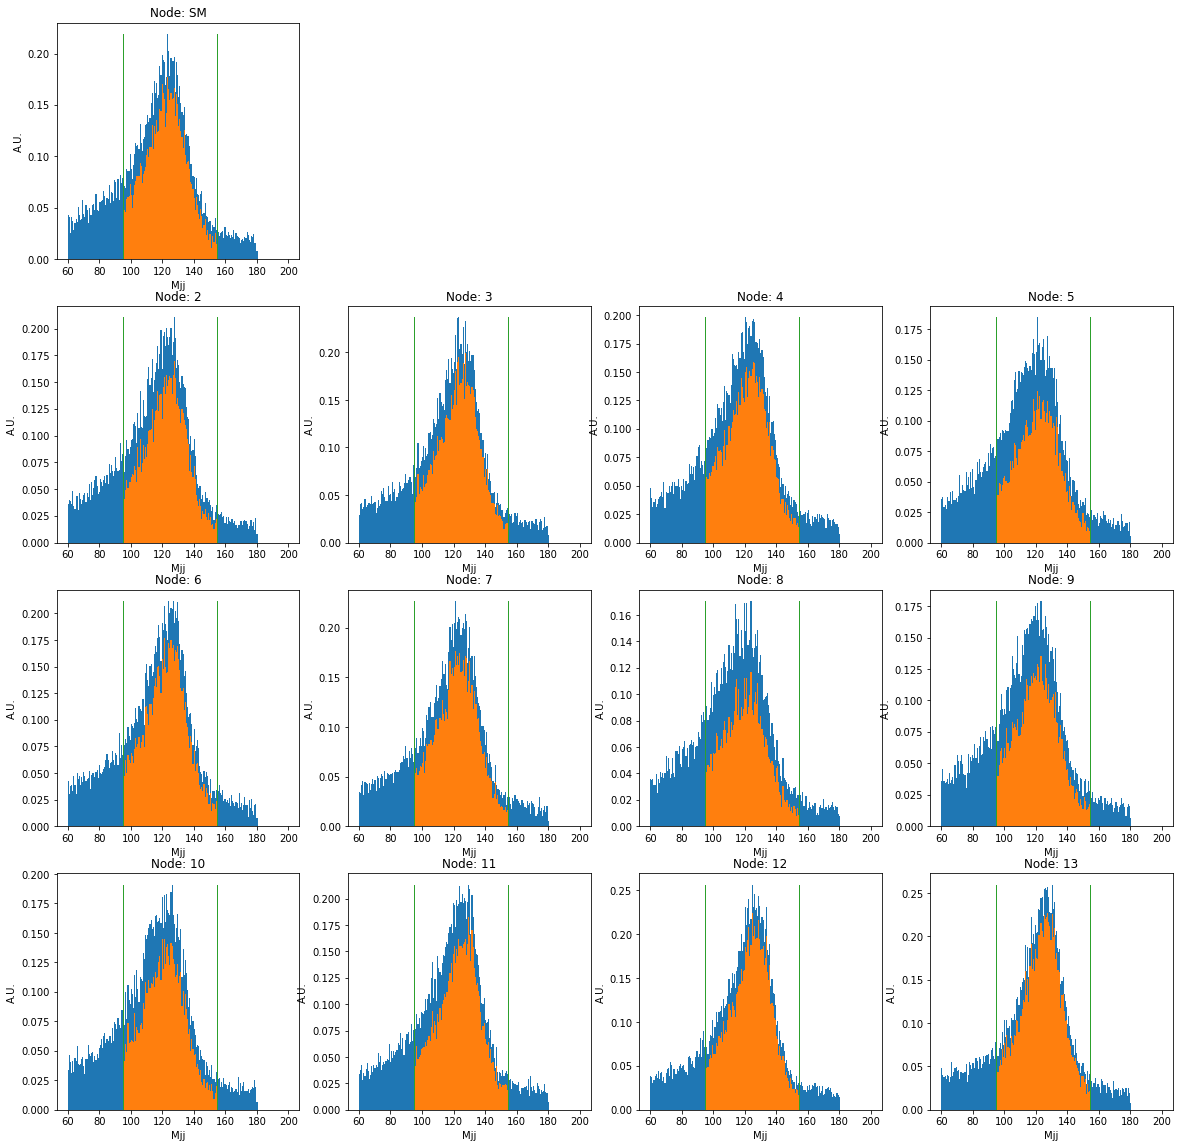

In [43]:
plt.figure(figsize=(20,20))
for group in grouped.groups:
    grp = grouped.get_group(group)
    plot_projection(grp,group,'Mjj',mjj_window,bins=200,range=[60.,200.])

#     plot_projection(grp,group,'MVAOutput',MX_categories,bins=200,range=[0.,1.])
#     all_ev,bins,_ = plt.hist(grp['Mjj'],weights=grp['weight'],bins=200,range=[60.,200.])
#     sel_ev,_,_ = plt.hist(grp['Mjj'],weights=grp['selected'],bins=200,range=[60.,200.])
#     plt.hist(mjj_window,bins=200,range=[60.,200.],weights=0.15*np.ones_like(mjj_window))
#     plt.show()
#     plt.plot(0.5*(bins[1:]+bins[:-1]),sel_ev/all_ev)
#     plt.show()

In [ ]:
efficiencies = df.groupby(['proc','MX_bin','MVA_bin'])['selected'].sum() / df.groupby('proc')['weight'].sum()

In [ ]:
# df.groupby(['proc'])['selected'].sum() / df.groupby('proc')['weight'].sum()

In [ ]:
procs = sorted(df['proc'].unique())
for proc in procs:
    print(proc, efficiencies.loc[proc].sum())
    effs = efficiencies.loc[proc].ravel()
    plt.bar(np.arange(0,effs.shape[0]),effs)#/effs.sum())
    plt.show()

In [ ]:
# help(plt.bar)